# Intro
## Coercion check

In identity verification systems, we need to ensure that people are who they say they are. However, given the range of services that verifying oneself can give access to, it's also important to establish that people verifying themselves are doing so out of their own volition (as opposed to being coerced or incentivised into doing so). A common indicator of this kind of fraud pattern is the presence of multiple people during the verification process.

This notebook is meant for proof-of-concepting a sort of a coercion check.

# Setup 
## Dependancies

In [72]:
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import defaultdict
import glob

## GPU
Making sure we're using the GPU for any CUDA calculations.

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4070


# Object Detection
## Model initialisation

For object detection, The YOLO series of models is really easy to set up and use. Here I am using the pretrained Yolov8 (Ultralytics) model and specifically the medium sized variant (nano, small and large models also exist, with model size leading to better object detection with diminishing returns).

In [6]:
model = YOLO("models/yolov8m.pt")  # yolov8n.pt, yolov8s.pt or yolov8m.pt for better accuracy

## Initial test

In [7]:
results = model("videos/veriff1.mp4", stream=True)
for result in results:
    print(result.boxes.cls)  # Class IDs (e.g. 0 for "person")


video 1/1 (frame 1/253) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff1.mp4: 384x640 1 person, 53.2ms
tensor([0.], device='cuda:0')
video 1/1 (frame 2/253) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff1.mp4: 384x640 1 person, 14.2ms
tensor([0.], device='cuda:0')
video 1/1 (frame 3/253) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff1.mp4: 384x640 1 person, 14.2ms
tensor([0.], device='cuda:0')
video 1/1 (frame 4/253) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff1.mp4: 384x640 1 person, 11.9ms
tensor([0.], device='cuda:0')
video 1/1 (frame 5/253) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff1.mp4: 384x640 1 person, 11.5ms
tensor([0.], device='cuda:0')
video 1/1 (frame 6/253) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff1.mp4: 384x640 1 person, 16.4ms
tensor([0.], device='cuda:0')
video 1/1 (frame 7/253) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff1.mp4: 384x640 1 person, 

In [8]:
def process_video_with_boxes(input_path, output_path, model):
    # Open the video file
    cap = cv2.VideoCapture(input_path)
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Process each frame
    for _ in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret:
            break
            
        # Run YOLOv8 inference on the frame
        results = model(frame)
        
        # Get the first result (only one image was processed)
        result = results[0]
        
        # Draw bounding boxes and labels on the frame
        for box in result.boxes:
            # Get box coordinates (convert to integers for drawing)
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Get class and confidence
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            
            # Get class name (you can customize this based on your model)
            class_names = model.names
            cls_name = class_names[cls_id]
            
            # Only annotate people (class 0) if you want to focus on coercion detection
            if cls_id == 0:  # person class
                # Draw rectangle
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Add label with confidence
                label = f"{cls_name}: {conf:.2f}"
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, (0, 255, 0), 2)
        
        # Write the frame to output video
        out.write(frame)
    
    # Release resources
    cap.release()
    out.release()
    return output_path

# Process the video and create a new one with bounding boxes
output_file = "videos/veriff1_annotated.mp4"
processed_video = process_video_with_boxes("videos/veriff1.mp4", output_file, model)

print(f"Video processed and saved as {output_file}")

  0%|          | 0/253 [00:00<?, ?it/s]


0: 384x640 1 person, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 2/253 [00:00<00:13, 18.66it/s]


0: 384x640 1 person, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.7ms
Speed: 1.9ms preprocess, 19.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 24.9ms
Speed: 1.4ms preprocess, 24.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 5/253 [00:00<00:12, 20.26it/s]


0: 384x640 1 person, 24.7ms
Speed: 1.2ms preprocess, 24.7ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 8/253 [00:00<00:11, 21.16it/s]


0: 384x640 1 person, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.5ms
Speed: 1.1ms preprocess, 16.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 11/253 [00:00<00:10, 22.94it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 14/253 [00:00<00:09, 23.97it/s]


0: 384x640 1 person, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 17/253 [00:00<00:09, 24.92it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 23.9ms
Speed: 1.2ms preprocess, 23.9ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 20/253 [00:00<00:09, 24.42it/s]


0: 384x640 1 person, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.9ms
Speed: 1.3ms preprocess, 15.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 23/253 [00:00<00:09, 24.88it/s]


0: 384x640 1 person, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 26/253 [00:01<00:09, 24.78it/s]


0: 384x640 1 person, 13.6ms
Speed: 1.3ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.5ms
Speed: 1.2ms preprocess, 15.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 11%|█▏        | 29/253 [00:01<00:08, 25.08it/s]


0: 384x640 1 person, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.6ms
Speed: 1.8ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.1ms
Speed: 1.4ms preprocess, 15.1ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 32/253 [00:01<00:08, 24.89it/s]


0: 384x640 1 person, 17.0ms
Speed: 1.2ms preprocess, 17.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 35/253 [00:01<00:08, 25.01it/s]


0: 384x640 1 person, 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 38/253 [00:01<00:08, 25.53it/s]


0: 384x640 1 person, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 41/253 [00:01<00:08, 25.35it/s]


0: 384x640 1 person, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 44/253 [00:01<00:08, 25.52it/s]


0: 384x640 1 person, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.4ms
Speed: 1.1ms preprocess, 15.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▊        | 47/253 [00:01<00:08, 25.35it/s]


0: 384x640 1 person, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.4ms
Speed: 1.8ms preprocess, 15.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 50/253 [00:02<00:08, 25.29it/s]


0: 384x640 1 person, 14.3ms
Speed: 1.2ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 53/253 [00:02<00:07, 25.45it/s]


0: 384x640 1 person, 13.3ms
Speed: 1.2ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 56/253 [00:02<00:07, 25.85it/s]


0: 384x640 1 person, 15.5ms
Speed: 1.2ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 59/253 [00:02<00:07, 25.67it/s]


0: 384x640 1 person, 15.3ms
Speed: 1.3ms preprocess, 15.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.5ms
Speed: 1.1ms preprocess, 15.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 62/253 [00:02<00:07, 25.80it/s]


0: 384x640 1 person, 14.4ms
Speed: 1.2ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 65/253 [00:02<00:07, 25.58it/s]


0: 384x640 1 person, 13.6ms
Speed: 1.5ms preprocess, 13.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 68/253 [00:02<00:07, 25.50it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.9ms
Speed: 1.8ms preprocess, 13.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 71/253 [00:02<00:07, 25.40it/s]


0: 384x640 1 person, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 74/253 [00:02<00:06, 25.93it/s]


0: 384x640 1 person, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 77/253 [00:03<00:06, 26.18it/s]


0: 384x640 1 person, 11.5ms
Speed: 1.1ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.0ms
Speed: 1.2ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 80/253 [00:03<00:06, 26.39it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.1ms
Speed: 1.3ms preprocess, 15.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 83/253 [00:03<00:06, 25.70it/s]


0: 384x640 1 person, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 28.8ms
Speed: 2.6ms preprocess, 28.8ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 86/253 [00:03<00:06, 24.94it/s]


0: 384x640 1 person, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 89/253 [00:03<00:06, 25.40it/s]


0: 384x640 1 person, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▋      | 92/253 [00:03<00:06, 25.50it/s]


0: 384x640 1 person, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 95/253 [00:03<00:06, 25.52it/s]


0: 384x640 1 person, 12.6ms
Speed: 1.2ms preprocess, 12.6ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.3ms
Speed: 1.2ms preprocess, 15.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.2ms
Speed: 1.2ms preprocess, 16.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▊      | 98/253 [00:03<00:06, 25.21it/s]


0: 384x640 1 person, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.2ms
Speed: 1.2ms preprocess, 15.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 101/253 [00:04<00:05, 25.39it/s]


0: 384x640 1 person, 15.2ms
Speed: 1.3ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 104/253 [00:04<00:05, 25.28it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.2ms
Speed: 1.5ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 107/253 [00:04<00:05, 24.87it/s]


0: 384x640 1 person, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 110/253 [00:04<00:05, 25.49it/s]


0: 384x640 1 person, 12.7ms
Speed: 1.3ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.2ms
Speed: 1.3ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.3ms
Speed: 1.6ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 113/253 [00:04<00:05, 25.55it/s]


0: 384x640 1 person, 14.7ms
Speed: 1.3ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 116/253 [00:04<00:05, 25.55it/s]


0: 384x640 1 person, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.2ms
Speed: 1.6ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 119/253 [00:04<00:05, 25.17it/s]


0: 384x640 1 person, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.1ms
Speed: 1.9ms preprocess, 15.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 122/253 [00:04<00:05, 25.42it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 1.4ms preprocess, 12.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.6ms
Speed: 1.3ms preprocess, 13.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 125/253 [00:04<00:05, 25.50it/s]


0: 384x640 1 person, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 128/253 [00:05<00:04, 25.73it/s]


0: 384x640 2 persons, 1 cell phone, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cell phone, 13.5ms
Speed: 1.1ms preprocess, 13.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cell phone, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 131/253 [00:05<00:04, 24.63it/s]


0: 384x640 2 persons, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 12.3ms
Speed: 1.6ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 134/253 [00:05<00:04, 24.45it/s]


0: 384x640 1 person, 1 cell phone, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 remote, 1 cell phone, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 137/253 [00:05<00:04, 24.30it/s]


0: 384x640 1 person, 1 donut, 1 cell phone, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 1 cell phone, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 1 cell phone, 14.4ms
Speed: 1.4ms preprocess, 14.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 140/253 [00:05<00:04, 24.07it/s]


0: 384x640 2 persons, 1 cell phone, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cell phone, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 143/253 [00:05<00:04, 23.74it/s]


0: 384x640 2 persons, 1 cell phone, 15.7ms
Speed: 1.2ms preprocess, 15.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 146/253 [00:05<00:04, 23.69it/s]


0: 384x640 2 persons, 1 cell phone, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 cell phone, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 149/253 [00:05<00:04, 23.63it/s]


0: 384x640 1 person, 1 cell phone, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 14.5ms
Speed: 1.8ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 152/253 [00:06<00:04, 23.57it/s]


0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████▏   | 155/253 [00:06<00:04, 23.52it/s]


0: 384x640 1 person, 1 cell phone, 15.4ms
Speed: 1.3ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 22.3ms
Speed: 1.2ms preprocess, 22.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 158/253 [00:06<00:04, 22.37it/s]


0: 384x640 1 person, 1 cell phone, 22.2ms
Speed: 1.3ms preprocess, 22.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 1 cell phone, 23.9ms
Speed: 1.3ms preprocess, 23.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 23.6ms
Speed: 1.3ms preprocess, 23.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▎   | 161/253 [00:06<00:04, 20.95it/s]


0: 384x640 1 person, 1 remote, 1 cell phone, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 remote, 1 refrigerator, 21.3ms
Speed: 1.3ms preprocess, 21.3ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 remote, 1 cell phone, 25.6ms
Speed: 1.3ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 164/253 [00:06<00:04, 19.71it/s]


0: 384x640 1 person, 1 remote, 22.1ms
Speed: 1.5ms preprocess, 22.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 24.9ms
Speed: 1.4ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 22.0ms
Speed: 1.2ms preprocess, 22.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 167/253 [00:06<00:04, 19.28it/s]


0: 384x640 1 person, 21.0ms
Speed: 1.2ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 donut, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 donut, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 170/253 [00:07<00:04, 20.32it/s]


0: 384x640 1 person, 1 donut, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 173/253 [00:07<00:03, 21.29it/s]


0: 384x640 1 person, 1 refrigerator, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 176/253 [00:07<00:03, 22.52it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.6ms
Speed: 1.3ms preprocess, 15.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 179/253 [00:07<00:03, 23.06it/s]


0: 384x640 1 person, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 182/253 [00:07<00:02, 23.82it/s]


0: 384x640 1 person, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.9ms
Speed: 1.6ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 185/253 [00:07<00:02, 24.25it/s]


0: 384x640 1 person, 1 refrigerator, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 188/253 [00:07<00:02, 24.26it/s]


0: 384x640 1 person, 1 refrigerator, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 1 teddy bear, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 15.9ms
Speed: 1.9ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▌  | 191/253 [00:07<00:02, 23.85it/s]


0: 384x640 1 person, 14.1ms
Speed: 1.1ms preprocess, 14.1ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 microwave, 1 refrigerator, 25.7ms
Speed: 1.2ms preprocess, 25.7ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 194/253 [00:08<00:02, 23.34it/s]


0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 197/253 [00:08<00:02, 24.11it/s]


0: 384x640 1 person, 24.9ms
Speed: 1.2ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 200/253 [00:08<00:02, 24.05it/s]


0: 384x640 1 person, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 203/253 [00:08<00:02, 24.69it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████▏ | 206/253 [00:08<00:01, 25.30it/s]


0: 384x640 1 person, 1 refrigerator, 18.6ms
Speed: 1.2ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 209/253 [00:08<00:01, 25.06it/s]


0: 384x640 1 person, 1 refrigerator, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 212/253 [00:08<00:01, 25.20it/s]


0: 384x640 2 persons, 1 book, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 microwave, 1 refrigerator, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 21.7ms
Speed: 1.4ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 215/253 [00:08<00:01, 24.40it/s]


0: 384x640 1 person, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 20.8ms
Speed: 2.2ms preprocess, 20.8ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 218/253 [00:08<00:01, 24.22it/s]


0: 384x640 1 person, 1 refrigerator, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 221/253 [00:09<00:01, 24.39it/s]


0: 384x640 1 person, 22.6ms
Speed: 1.3ms preprocess, 22.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 12.6ms
Speed: 1.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▊ | 224/253 [00:09<00:01, 24.11it/s]


0: 384x640 1 person, 1 donut, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 1 refrigerator, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 227/253 [00:09<00:01, 24.06it/s]


0: 384x640 1 person, 1 donut, 21.6ms
Speed: 1.2ms preprocess, 21.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 24.2ms
Speed: 1.8ms preprocess, 24.2ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 1 refrigerator, 24.2ms
Speed: 1.2ms preprocess, 24.2ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 230/253 [00:09<00:01, 21.53it/s]


0: 384x640 1 person, 1 refrigerator, 20.3ms
Speed: 1.3ms preprocess, 20.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 10.7ms
Speed: 1.5ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 donut, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 233/253 [00:09<00:00, 21.81it/s]


0: 384x640 1 person, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 236/253 [00:09<00:00, 22.98it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.0ms
Speed: 1.1ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 239/253 [00:09<00:00, 24.20it/s]


0: 384x640 1 person, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 242/253 [00:09<00:00, 25.27it/s]


0: 384x640 1 person, 11.1ms
Speed: 1.1ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 245/253 [00:10<00:00, 25.66it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 248/253 [00:10<00:00, 26.04it/s]


0: 384x640 1 person, 19.4ms
Speed: 1.2ms preprocess, 19.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 refrigerators, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 251/253 [00:10<00:00, 25.15it/s]


0: 384x640 1 person, 1 refrigerator, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 refrigerator, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 253/253 [00:10<00:00, 24.25it/s]

Video processed and saved as videos/veriff1_annotated.mp4


In [9]:
# Process the video and create a new one with bounding boxes
output_file = "videos/veriff18_annotated.mp4"
processed_video = process_video_with_boxes("videos/veriff18.mp4", output_file, model)

print(f"Video processed and saved as {output_file}")

  0%|          | 0/396 [00:00<?, ?it/s]


0: 384x640 1 person, 1 dog, 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 2/396 [00:00<00:22, 17.65it/s]


0: 384x640 3 persons, 1 dog, 11.8ms
Speed: 1.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 21.9ms
Speed: 1.6ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  1%|▏         | 5/396 [00:00<00:18, 20.99it/s]


0: 384x640 2 persons, 1 dog, 12.8ms
Speed: 1.6ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 8/396 [00:00<00:17, 21.77it/s]


0: 384x640 2 persons, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 11/396 [00:00<00:16, 23.39it/s]


0: 384x640 3 persons, 1 dog, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 14/396 [00:00<00:15, 24.46it/s]


0: 384x640 1 person, 1 dog, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 16.5ms
Speed: 1.8ms preprocess, 16.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 14.7ms
Speed: 1.4ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 17/396 [00:00<00:15, 24.23it/s]


0: 384x640 1 person, 1 dog, 16.1ms
Speed: 1.5ms preprocess, 16.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 12.8ms
Speed: 1.3ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 22.9ms
Speed: 2.4ms preprocess, 22.9ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 20/396 [00:00<00:16, 23.48it/s]


0: 384x640 3 persons, 1 dog, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 19.0ms
Speed: 1.3ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 remote, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  6%|▌         | 23/396 [00:00<00:15, 23.62it/s]


0: 384x640 3 persons, 1 dog, 1 remote, 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 book, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 26/396 [00:01<00:15, 23.76it/s]


0: 384x640 2 persons, 1 dog, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 remote, 1 book, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 29/396 [00:01<00:15, 23.47it/s]


0: 384x640 2 persons, 1 dog, 1 remote, 1 book, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 book, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 32/396 [00:01<00:15, 23.65it/s]


0: 384x640 1 person, 1 dog, 1 donut, 1 book, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 donut, 1 book, 23.1ms
Speed: 1.4ms preprocess, 23.1ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cat, 1 dog, 1 donut, 1 book, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 35/396 [00:01<00:16, 22.19it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 10%|▉         | 38/396 [00:01<00:15, 22.91it/s]


0: 384x640 2 persons, 1 dog, 1 book, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 41/396 [00:01<00:15, 23.03it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 44/396 [00:01<00:15, 23.20it/s]


0: 384x640 2 persons, 1 dog, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 carrot, 1 book, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 donut, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 47/396 [00:02<00:14, 23.56it/s]


0: 384x640 3 persons, 1 dog, 1 book, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 19.1ms
Speed: 1.4ms preprocess, 19.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 20.9ms
Speed: 1.6ms preprocess, 20.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 50/396 [00:02<00:15, 22.83it/s]


0: 384x640 2 persons, 1 dog, 1 donut, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 53/396 [00:02<00:14, 23.43it/s]


0: 384x640 2 persons, 1 dog, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 donut, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 15.0ms
Speed: 1.4ms preprocess, 15.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 56/396 [00:02<00:14, 23.60it/s]


0: 384x640 2 persons, 1 dog, 1 donut, 1 book, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▍        | 59/396 [00:02<00:14, 24.00it/s]


0: 384x640 2 persons, 1 dog, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 bottle, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 62/396 [00:02<00:13, 24.68it/s]


0: 384x640 2 persons, 1 dog, 1 remote, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▋        | 65/396 [00:02<00:13, 24.57it/s]


0: 384x640 2 persons, 1 bottle, 1 remote, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 68/396 [00:02<00:13, 24.55it/s]


0: 384x640 1 person, 1 dog, 1 bottle, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 13.2ms
Speed: 1.6ms preprocess, 13.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 71/396 [00:03<00:13, 24.40it/s]


0: 384x640 1 person, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▊        | 74/396 [00:03<00:12, 25.15it/s]


0: 384x640 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 77/396 [00:03<00:12, 25.41it/s]


0: 384x640 2 persons, 1 bottle, 1 book, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 1 book, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 20%|██        | 80/396 [00:03<00:13, 24.31it/s]


0: 384x640 2 persons, 1 book, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 14.3ms
Speed: 1.6ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 83/396 [00:03<00:13, 23.92it/s]


0: 384x640 3 persons, 1 book, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 86/396 [00:03<00:12, 23.88it/s]


0: 384x640 3 persons, 1 book, 23.1ms
Speed: 1.4ms preprocess, 23.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 book, 22.8ms
Speed: 1.4ms preprocess, 22.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 23.2ms
Speed: 1.8ms preprocess, 23.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 89/396 [00:03<00:14, 21.78it/s]


0: 384x640 3 persons, 1 book, 23.6ms
Speed: 1.7ms preprocess, 23.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 19.9ms
Speed: 1.6ms preprocess, 19.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 92/396 [00:03<00:14, 20.62it/s]


0: 384x640 2 persons, 1 book, 22.0ms
Speed: 1.5ms preprocess, 22.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 20.9ms
Speed: 1.4ms preprocess, 20.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▍       | 95/396 [00:04<00:14, 20.34it/s]


0: 384x640 2 persons, 17.7ms
Speed: 1.4ms preprocess, 17.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 21.3ms
Speed: 1.4ms preprocess, 21.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 18.0ms
Speed: 1.4ms preprocess, 18.0ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 98/396 [00:04<00:14, 20.87it/s]


0: 384x640 2 persons, 20.5ms
Speed: 1.4ms preprocess, 20.5ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 books, 21.4ms
Speed: 1.4ms preprocess, 21.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 20.7ms
Speed: 1.4ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 101/396 [00:04<00:14, 20.46it/s]


0: 384x640 3 persons, 14.2ms
Speed: 1.7ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▋       | 104/396 [00:04<00:13, 21.42it/s]


0: 384x640 2 persons, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 15.5ms
Speed: 1.5ms preprocess, 15.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 107/396 [00:04<00:13, 21.92it/s]


0: 384x640 2 persons, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.1ms
Speed: 1.3ms preprocess, 13.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 110/396 [00:04<00:12, 23.27it/s]


0: 384x640 2 persons, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 113/396 [00:04<00:11, 23.72it/s]


0: 384x640 2 persons, 1 refrigerator, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 116/396 [00:05<00:12, 23.32it/s]


0: 384x640 2 persons, 1 refrigerator, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 119/396 [00:05<00:11, 23.59it/s]


0: 384x640 3 persons, 2 refrigerators, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 14.1ms
Speed: 1.3ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 31%|███       | 122/396 [00:05<00:11, 23.77it/s]


0: 384x640 4 persons, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 125/396 [00:05<00:11, 24.23it/s]


0: 384x640 3 persons, 13.2ms
Speed: 1.3ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 128/396 [00:05<00:10, 24.58it/s]


0: 384x640 4 persons, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 131/396 [00:05<00:10, 24.78it/s]


0: 384x640 3 persons, 16.4ms
Speed: 1.3ms preprocess, 16.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 134/396 [00:05<00:10, 25.06it/s]


0: 384x640 3 persons, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▍      | 137/396 [00:05<00:10, 25.34it/s]


0: 384x640 4 persons, 13.2ms
Speed: 1.3ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.7ms
Speed: 1.5ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 140/396 [00:05<00:10, 24.89it/s]


0: 384x640 3 persons, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 143/396 [00:06<00:10, 25.16it/s]


0: 384x640 3 persons, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 refrigerator, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 146/396 [00:06<00:09, 25.34it/s]


0: 384x640 4 persons, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 refrigerator, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 149/396 [00:06<00:09, 25.29it/s]


0: 384x640 3 persons, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 152/396 [00:06<00:09, 25.18it/s]


0: 384x640 3 persons, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 155/396 [00:06<00:09, 25.12it/s]


0: 384x640 3 persons, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 10.8ms
Speed: 1.3ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 40%|███▉      | 158/396 [00:06<00:09, 25.83it/s]


0: 384x640 4 persons, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 21.3ms
Speed: 1.3ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 161/396 [00:06<00:09, 25.18it/s]


0: 384x640 4 persons, 1 book, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 book, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 41%|████▏     | 164/396 [00:06<00:09, 24.49it/s]


0: 384x640 2 persons, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 167/396 [00:07<00:09, 25.06it/s]


0: 384x640 3 persons, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 170/396 [00:07<00:08, 25.66it/s]


0: 384x640 3 persons, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 book, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 16.1ms
Speed: 1.7ms preprocess, 16.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▎     | 173/396 [00:07<00:09, 24.77it/s]


0: 384x640 3 persons, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 176/396 [00:07<00:08, 24.67it/s]


0: 384x640 2 persons, 1 book, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 15.5ms
Speed: 1.4ms preprocess, 15.5ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▌     | 179/396 [00:07<00:09, 23.57it/s]


0: 384x640 2 persons, 1 book, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 15.3ms
Speed: 1.9ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 182/396 [00:07<00:09, 23.68it/s]


0: 384x640 3 persons, 1 book, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 185/396 [00:07<00:08, 23.76it/s]


0: 384x640 2 persons, 1 book, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 refrigerator, 1 book, 14.2ms
Speed: 1.7ms preprocess, 14.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 188/396 [00:07<00:08, 23.34it/s]


0: 384x640 3 persons, 1 refrigerator, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 1.4ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 191/396 [00:08<00:08, 23.96it/s]


0: 384x640 1 person, 1 book, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▉     | 194/396 [00:08<00:08, 24.12it/s]


0: 384x640 2 persons, 1 book, 18.2ms
Speed: 1.7ms preprocess, 18.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 18.3ms
Speed: 1.7ms preprocess, 18.3ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 197/396 [00:08<00:08, 22.55it/s]


0: 384x640 3 persons, 1 book, 14.3ms
Speed: 1.4ms preprocess, 14.3ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 14.1ms
Speed: 1.6ms preprocess, 14.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 200/396 [00:08<00:09, 21.06it/s]


0: 384x640 3 persons, 1 book, 13.4ms
Speed: 1.7ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 26.9ms
Speed: 1.9ms preprocess, 26.9ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 12.4ms
Speed: 1.8ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████▏    | 203/396 [00:08<00:09, 20.33it/s]


0: 384x640 2 persons, 1 book, 13.2ms
Speed: 1.4ms preprocess, 13.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 13.2ms
Speed: 1.4ms preprocess, 13.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 12.9ms
Speed: 1.4ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 206/396 [00:08<00:09, 20.99it/s]


0: 384x640 4 persons, 1 book, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 book, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 book, 19.3ms
Speed: 1.5ms preprocess, 19.3ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 209/396 [00:08<00:09, 20.74it/s]


0: 384x640 4 persons, 1 book, 14.0ms
Speed: 2.3ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 book, 12.5ms
Speed: 1.8ms preprocess, 12.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 book, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▎    | 212/396 [00:09<00:08, 20.91it/s]


0: 384x640 3 persons, 1 book, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 22.4ms
Speed: 1.4ms preprocess, 22.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 215/396 [00:09<00:08, 20.88it/s]


0: 384x640 3 persons, 1 book, 16.2ms
Speed: 1.3ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 218/396 [00:09<00:08, 21.88it/s]


0: 384x640 2 persons, 1 book, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 17.0ms
Speed: 1.6ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▌    | 221/396 [00:09<00:07, 22.14it/s]


0: 384x640 2 persons, 1 dog, 1 book, 23.5ms
Speed: 1.4ms preprocess, 23.5ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 224/396 [00:09<00:08, 21.40it/s]


0: 384x640 3 persons, 1 book, 18.4ms
Speed: 2.0ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 book, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 227/396 [00:09<00:07, 21.62it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 book, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 230/396 [00:09<00:07, 22.06it/s]


0: 384x640 3 persons, 1 dog, 1 book, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 233/396 [00:10<00:07, 22.26it/s]


0: 384x640 2 persons, 1 dog, 1 book, 22.7ms
Speed: 2.0ms preprocess, 22.7ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 22.3ms
Speed: 1.6ms preprocess, 22.3ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


 60%|█████▉    | 236/396 [00:10<00:07, 21.05it/s]


0: 384x640 1 person, 1 dog, 1 book, 21.6ms
Speed: 1.5ms preprocess, 21.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 book, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 22.1ms
Speed: 1.4ms preprocess, 22.1ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 239/396 [00:10<00:07, 20.56it/s]


0: 384x640 2 persons, 1 dog, 1 book, 16.3ms
Speed: 1.4ms preprocess, 16.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 15.9ms
Speed: 1.4ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 242/396 [00:10<00:07, 20.71it/s]


0: 384x640 2 persons, 2 dogs, 1 book, 12.0ms
Speed: 1.5ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 245/396 [00:10<00:07, 21.38it/s]


0: 384x640 1 person, 1 dog, 1 book, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 dogs, 1 book, 21.9ms
Speed: 1.6ms preprocess, 21.9ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 248/396 [00:10<00:06, 21.33it/s]


0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 dogs, 1 book, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 251/396 [00:10<00:06, 22.19it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 22.1ms
Speed: 1.4ms preprocess, 22.1ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 254/396 [00:11<00:06, 21.74it/s]


0: 384x640 2 persons, 1 book, 22.2ms
Speed: 1.4ms preprocess, 22.2ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▍   | 257/396 [00:11<00:06, 21.47it/s]


0: 384x640 2 persons, 1 dog, 1 book, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 260/396 [00:11<00:06, 22.22it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.2ms
Speed: 1.6ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 book, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 22.2ms
Speed: 1.4ms preprocess, 22.2ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▋   | 263/396 [00:11<00:06, 21.91it/s]


0: 384x640 1 person, 1 dog, 1 book, 21.8ms
Speed: 1.5ms preprocess, 21.8ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 1 book, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 266/396 [00:11<00:05, 22.01it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 21.8ms
Speed: 1.5ms preprocess, 21.8ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 17.9ms
Speed: 1.5ms preprocess, 17.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 269/396 [00:11<00:06, 21.15it/s]


0: 384x640 2 persons, 1 dog, 1 book, 21.8ms
Speed: 2.0ms preprocess, 21.8ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 18.1ms
Speed: 1.4ms preprocess, 18.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▊   | 272/396 [00:11<00:06, 20.53it/s]


0: 384x640 1 person, 1 dog, 1 book, 13.3ms
Speed: 1.4ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 book, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 17.5ms
Speed: 1.4ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 275/396 [00:12<00:05, 21.09it/s]


0: 384x640 1 person, 1 dog, 1 book, 22.8ms
Speed: 1.4ms preprocess, 22.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 2 dogs, 1 book, 21.4ms
Speed: 1.5ms preprocess, 21.4ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 21.1ms
Speed: 1.4ms preprocess, 21.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 70%|███████   | 278/396 [00:12<00:05, 20.42it/s]


0: 384x640 1 person, 2 dogs, 1 book, 24.4ms
Speed: 1.4ms preprocess, 24.4ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 bottle, 18.9ms
Speed: 1.4ms preprocess, 18.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 21.3ms
Speed: 1.5ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 281/396 [00:12<00:05, 20.08it/s]


0: 384x640 2 persons, 1 dog, 1 bottle, 20.6ms
Speed: 1.4ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 bottle, 21.2ms
Speed: 1.5ms preprocess, 21.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 22.9ms
Speed: 1.9ms preprocess, 22.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 284/396 [00:12<00:05, 20.07it/s]


0: 384x640 2 persons, 1 dog, 22.4ms
Speed: 1.8ms preprocess, 22.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 19.8ms
Speed: 1.4ms preprocess, 19.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 18.6ms
Speed: 1.6ms preprocess, 18.6ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 287/396 [00:12<00:05, 19.88it/s]


0: 384x640 1 person, 18.2ms
Speed: 1.4ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 21.7ms
Speed: 1.5ms preprocess, 21.7ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 25.2ms
Speed: 2.6ms preprocess, 25.2ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 290/396 [00:12<00:05, 20.18it/s]


0: 384x640 2 persons, 17.6ms
Speed: 1.4ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▍  | 293/396 [00:12<00:04, 21.06it/s]


0: 384x640 1 person, 1 book, 15.3ms
Speed: 1.3ms preprocess, 15.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 remote, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 296/396 [00:13<00:04, 21.59it/s]


0: 384x640 2 persons, 1 remote, 1 book, 16.9ms
Speed: 1.3ms preprocess, 16.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 299/396 [00:13<00:04, 22.10it/s]


0: 384x640 1 person, 1 dog, 1 book, 11.7ms
Speed: 1.5ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 23.5ms
Speed: 1.4ms preprocess, 23.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▋  | 302/396 [00:13<00:04, 22.06it/s]


0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 305/396 [00:13<00:03, 22.78it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 book, 12.8ms
Speed: 1.4ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 308/396 [00:13<00:03, 23.01it/s]


0: 384x640 1 person, 1 dog, 1 book, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 13.0ms
Speed: 1.3ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 19.9ms
Speed: 1.8ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▊  | 311/396 [00:13<00:03, 23.02it/s]


0: 384x640 1 person, 1 dog, 1 bottle, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 bottle, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 314/396 [00:13<00:03, 23.93it/s]


0: 384x640 1 person, 1 dog, 1 book, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 317/396 [00:13<00:03, 24.31it/s]


0: 384x640 1 person, 2 dogs, 1 book, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 26.0ms
Speed: 1.5ms preprocess, 26.0ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████  | 320/396 [00:14<00:03, 23.03it/s]


0: 384x640 2 persons, 1 dog, 1 book, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 323/396 [00:14<00:03, 23.54it/s]


0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 326/396 [00:14<00:02, 23.80it/s]


0: 384x640 1 person, 1 dog, 1 book, 22.4ms
Speed: 1.4ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 29.9ms
Speed: 1.5ms preprocess, 29.9ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 329/396 [00:14<00:03, 22.02it/s]


0: 384x640 1 person, 1 dog, 1 book, 20.6ms
Speed: 1.5ms preprocess, 20.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 332/396 [00:14<00:02, 22.24it/s]


0: 384x640 1 person, 1 dog, 1 book, 15.2ms
Speed: 1.3ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 13.6ms
Speed: 1.3ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▍ | 335/396 [00:14<00:02, 22.76it/s]


0: 384x640 1 person, 1 dog, 1 book, 14.8ms
Speed: 1.4ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 12.6ms
Speed: 1.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 338/396 [00:14<00:02, 22.95it/s]


0: 384x640 1 person, 1 dog, 1 book, 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 bottle, 1 book, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 341/396 [00:14<00:02, 23.28it/s]


0: 384x640 2 persons, 1 dog, 1 book, 14.1ms
Speed: 1.3ms preprocess, 14.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 23.5ms
Speed: 1.9ms preprocess, 23.5ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 344/396 [00:15<00:02, 22.65it/s]


0: 384x640 1 person, 1 dog, 1 book, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 15.5ms
Speed: 1.3ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 347/396 [00:15<00:02, 22.76it/s]


0: 384x640 1 person, 1 dog, 1 book, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 2 dogs, 1 book, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 16.0ms
Speed: 1.4ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 350/396 [00:15<00:01, 23.01it/s]


0: 384x640 2 persons, 1 dog, 1 book, 18.0ms
Speed: 1.7ms preprocess, 18.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 15.7ms
Speed: 1.7ms preprocess, 15.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 353/396 [00:15<00:01, 22.67it/s]


0: 384x640 2 persons, 1 dog, 1 book, 12.5ms
Speed: 1.6ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 90%|████████▉ | 356/396 [00:15<00:01, 22.55it/s]


0: 384x640 1 person, 1 dog, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 14.4ms
Speed: 1.6ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 359/396 [00:15<00:01, 23.35it/s]


0: 384x640 2 persons, 1 dog, 11.1ms
Speed: 1.4ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████▏| 362/396 [00:15<00:01, 24.04it/s]


0: 384x640 1 person, 1 dog, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 book, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 donut, 1 book, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 365/396 [00:15<00:01, 24.01it/s]


0: 384x640 1 dog, 1 book, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 dog, 1 book, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 book, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 368/396 [00:16<00:01, 23.64it/s]


0: 384x640 1 person, 1 dog, 15.7ms
Speed: 1.3ms preprocess, 15.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cat, 1 dog, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 13.1ms
Speed: 1.4ms preprocess, 13.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▎| 371/396 [00:16<00:01, 23.77it/s]


0: 384x640 2 persons, 1 dog, 1 remote, 13.7ms
Speed: 1.4ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 1 remote, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 374/396 [00:16<00:00, 24.11it/s]


0: 384x640 1 person, 1 dog, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 12.9ms
Speed: 1.5ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▌| 377/396 [00:16<00:00, 24.11it/s]


0: 384x640 1 person, 1 dog, 10.7ms
Speed: 1.5ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.9ms
Speed: 1.4ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 380/396 [00:16<00:00, 24.60it/s]


0: 384x640 3 persons, 1 dog, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 383/396 [00:16<00:00, 24.34it/s]


0: 384x640 2 persons, 1 dog, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 13.2ms
Speed: 1.5ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 386/396 [00:16<00:00, 24.80it/s]


0: 384x640 2 persons, 1 dog, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 14.8ms
Speed: 1.3ms preprocess, 14.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 389/396 [00:16<00:00, 25.02it/s]


0: 384x640 3 persons, 1 dog, 14.9ms
Speed: 1.3ms preprocess, 14.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 dog, 14.7ms
Speed: 1.5ms preprocess, 14.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▉| 392/396 [00:17<00:00, 24.53it/s]


0: 384x640 2 persons, 1 dog, 12.7ms
Speed: 1.3ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 dog, 15.1ms
Speed: 1.3ms preprocess, 15.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 395/396 [00:17<00:00, 24.41it/s]


0: 384x640 1 person, 1 dog, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 396/396 [00:17<00:00, 22.94it/s]

Video processed and saved as videos/veriff18_annotated.mp4


In [10]:
# Process the video and create a new one with bounding boxes
output_file = "videos/veriff10_annotated.mp4"
processed_video = process_video_with_boxes("videos/veriff10.mp4", output_file, model)

print(f"Video processed and saved as {output_file}")

  0%|          | 0/312 [00:00<?, ?it/s]


0: 384x640 1 person, 12.7ms
Speed: 1.7ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  1%|          | 2/312 [00:00<00:16, 18.74it/s]


0: 384x640 1 person, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.0ms
Speed: 1.5ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 18.8ms
Speed: 1.2ms preprocess, 18.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  2%|▏         | 5/312 [00:00<00:14, 21.89it/s]


0: 384x640 1 person, 15.4ms
Speed: 1.2ms preprocess, 15.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


  3%|▎         | 8/312 [00:00<00:12, 23.68it/s]


0: 384x640 1 person, 14.9ms
Speed: 1.8ms preprocess, 14.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  4%|▎         | 11/312 [00:00<00:12, 24.33it/s]


0: 384x640 1 person, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  4%|▍         | 14/312 [00:00<00:11, 24.89it/s]


0: 384x640 1 person, 15.1ms
Speed: 1.2ms preprocess, 15.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  5%|▌         | 17/312 [00:00<00:11, 24.62it/s]


0: 384x640 1 person, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  6%|▋         | 20/312 [00:00<00:11, 24.87it/s]


0: 384x640 1 person, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


  7%|▋         | 23/312 [00:00<00:11, 24.93it/s]


0: 384x640 1 person, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


  8%|▊         | 26/312 [00:01<00:11, 25.65it/s]


0: 384x640 1 person, 12.5ms
Speed: 1.2ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


  9%|▉         | 29/312 [00:01<00:11, 25.15it/s]


0: 384x640 1 person, 1 cell phone, 12.2ms
Speed: 1.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 laptop, 1 cell phone, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 10%|█         | 32/312 [00:01<00:11, 24.55it/s]


0: 384x640 1 person, 1 book, 14.6ms
Speed: 1.6ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.3ms
Speed: 1.3ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 11%|█         | 35/312 [00:01<00:11, 24.30it/s]


0: 384x640 1 person, 1 cell phone, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 12%|█▏        | 38/312 [00:01<00:11, 24.59it/s]


0: 384x640 1 person, 1 cell phone, 15.3ms
Speed: 1.2ms preprocess, 15.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 10.8ms
Speed: 1.4ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 13%|█▎        | 41/312 [00:01<00:11, 24.18it/s]


0: 384x640 1 person, 1 cell phone, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.4ms
Speed: 1.5ms preprocess, 15.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 14%|█▍        | 44/312 [00:01<00:11, 24.26it/s]


0: 384x640 1 person, 11.7ms
Speed: 1.5ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.8ms
Speed: 1.5ms preprocess, 13.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 15%|█▌        | 47/312 [00:01<00:10, 24.75it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 20.3ms
Speed: 1.4ms preprocess, 20.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 dog, 1 cell phone, 15.0ms
Speed: 1.2ms preprocess, 15.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 16%|█▌        | 50/312 [00:02<00:10, 23.94it/s]


0: 384x640 1 person, 1 cell phone, 15.2ms
Speed: 1.2ms preprocess, 15.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 17%|█▋        | 53/312 [00:02<00:10, 23.83it/s]


0: 384x640 1 person, 1 cell phone, 14.6ms
Speed: 1.6ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.0ms
Speed: 1.2ms preprocess, 11.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 18%|█▊        | 56/312 [00:02<00:10, 23.89it/s]


0: 384x640 1 person, 1 cell phone, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 13.1ms
Speed: 1.4ms preprocess, 13.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.8ms
Speed: 1.5ms preprocess, 11.8ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)


 19%|█▉        | 59/312 [00:02<00:10, 23.08it/s]


0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 20%|█▉        | 62/312 [00:02<00:10, 23.65it/s]


0: 384x640 1 person, 1 cell phone, 14.3ms
Speed: 1.2ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.7ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 21%|██        | 65/312 [00:02<00:10, 23.98it/s]


0: 384x640 1 person, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 22%|██▏       | 68/312 [00:02<00:10, 24.02it/s]


0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 23%|██▎       | 71/312 [00:02<00:09, 24.21it/s]


0: 384x640 1 person, 1 cell phone, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 24%|██▎       | 74/312 [00:03<00:09, 24.40it/s]


0: 384x640 1 person, 1 cell phone, 11.4ms
Speed: 1.3ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 25%|██▍       | 77/312 [00:03<00:09, 24.14it/s]


0: 384x640 1 person, 1 cell phone, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 26%|██▌       | 80/312 [00:03<00:09, 23.95it/s]


0: 384x640 2 persons, 1 cell phone, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 14.9ms
Speed: 1.4ms preprocess, 14.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


 27%|██▋       | 83/312 [00:03<00:09, 23.92it/s]


0: 384x640 1 person, 1 cell phone, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 14.7ms
Speed: 1.3ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 28%|██▊       | 86/312 [00:03<00:09, 23.97it/s]


0: 384x640 1 person, 1 cell phone, 10.9ms
Speed: 1.3ms preprocess, 10.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 16.1ms
Speed: 1.3ms preprocess, 16.1ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.8ms
Speed: 1.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▊       | 89/312 [00:03<00:09, 23.01it/s]


0: 384x640 1 person, 1 cell phone, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 remote, 1 cell phone, 12.1ms
Speed: 1.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.1ms
Speed: 1.3ms preprocess, 11.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 29%|██▉       | 92/312 [00:03<00:09, 22.99it/s]


0: 384x640 1 person, 1 book, 19.3ms
Speed: 1.3ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 1 book, 14.5ms
Speed: 1.2ms preprocess, 14.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 30%|███       | 95/312 [00:03<00:09, 22.67it/s]


0: 384x640 1 person, 1 cup, 12.9ms
Speed: 1.3ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 11.6ms
Speed: 1.2ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 31%|███▏      | 98/312 [00:04<00:09, 23.30it/s]


0: 384x640 1 person, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 20.4ms
Speed: 1.7ms preprocess, 20.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 32%|███▏      | 101/312 [00:04<00:09, 23.25it/s]


0: 384x640 1 person, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.8ms
Speed: 1.4ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 17.4ms
Speed: 2.1ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 33%|███▎      | 104/312 [00:04<00:08, 23.34it/s]


0: 384x640 1 person, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 34%|███▍      | 107/312 [00:04<00:08, 24.05it/s]


0: 384x640 1 person, 13.1ms
Speed: 1.4ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.0ms
Speed: 1.2ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 35%|███▌      | 110/312 [00:04<00:08, 24.50it/s]


0: 384x640 1 person, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.8ms
Speed: 1.2ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 36%|███▌      | 113/312 [00:04<00:07, 25.21it/s]


0: 384x640 1 person, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 37%|███▋      | 116/312 [00:04<00:07, 25.44it/s]


0: 384x640 1 person, 15.9ms
Speed: 1.3ms preprocess, 15.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 38%|███▊      | 119/312 [00:04<00:07, 25.72it/s]


0: 384x640 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


 39%|███▉      | 122/312 [00:05<00:07, 26.24it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 18.5ms
Speed: 1.3ms preprocess, 18.5ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 40%|████      | 125/312 [00:05<00:07, 26.03it/s]


0: 384x640 1 person, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 41%|████      | 128/312 [00:05<00:07, 25.94it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 42%|████▏     | 131/312 [00:05<00:06, 25.92it/s]


0: 384x640 1 person, 17.2ms
Speed: 1.4ms preprocess, 17.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 43%|████▎     | 134/312 [00:05<00:06, 25.61it/s]


0: 384x640 1 person, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 44%|████▍     | 137/312 [00:05<00:06, 25.68it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.1ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 45%|████▍     | 140/312 [00:05<00:06, 25.72it/s]


0: 384x640 1 person, 11.4ms
Speed: 1.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.5ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 46%|████▌     | 143/312 [00:05<00:06, 25.82it/s]


0: 384x640 1 person, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 22.1ms
Speed: 1.3ms preprocess, 22.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 47%|████▋     | 146/312 [00:05<00:06, 25.35it/s]


0: 384x640 1 person, 23.7ms
Speed: 1.7ms preprocess, 23.7ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


 48%|████▊     | 149/312 [00:06<00:06, 24.67it/s]


0: 384x640 1 person, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 49%|████▊     | 152/312 [00:06<00:06, 25.25it/s]


0: 384x640 1 person, 1 cell phone, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.8ms
Speed: 1.2ms preprocess, 15.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 11.5ms
Speed: 1.3ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 50%|████▉     | 155/312 [00:06<00:06, 24.78it/s]


0: 384x640 1 person, 1 laptop, 13.6ms
Speed: 1.7ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 51%|█████     | 158/312 [00:06<00:06, 24.96it/s]


0: 384x640 1 person, 1 laptop, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 11.8ms
Speed: 1.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 52%|█████▏    | 161/312 [00:06<00:06, 24.57it/s]


0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 53%|█████▎    | 164/312 [00:06<00:06, 24.48it/s]


0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.1ms
Speed: 1.3ms preprocess, 14.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.8ms
Speed: 1.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▎    | 167/312 [00:06<00:05, 24.54it/s]


0: 384x640 1 person, 1 cell phone, 19.8ms
Speed: 1.3ms preprocess, 19.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 54%|█████▍    | 170/312 [00:06<00:05, 24.13it/s]


0: 384x640 1 person, 11.4ms
Speed: 1.5ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.3ms
Speed: 1.3ms preprocess, 11.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 55%|█████▌    | 173/312 [00:07<00:05, 24.38it/s]


0: 384x640 1 person, 1 cell phone, 14.7ms
Speed: 1.2ms preprocess, 14.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 56%|█████▋    | 176/312 [00:07<00:05, 24.49it/s]


0: 384x640 1 person, 1 cell phone, 11.6ms
Speed: 1.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 57%|█████▋    | 179/312 [00:07<00:05, 24.47it/s]


0: 384x640 1 person, 1 cell phone, 24.4ms
Speed: 1.4ms preprocess, 24.4ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 pizza, 1 cell phone, 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.1ms
Speed: 1.1ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 58%|█████▊    | 182/312 [00:07<00:05, 23.54it/s]


0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.5ms
Speed: 1.3ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 59%|█████▉    | 185/312 [00:07<00:05, 23.82it/s]


0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.2ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 13.6ms
Speed: 1.2ms preprocess, 13.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 60%|██████    | 188/312 [00:07<00:05, 23.97it/s]


0: 384x640 1 person, 1 cell phone, 12.3ms
Speed: 1.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 22.8ms
Speed: 1.7ms preprocess, 22.8ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 61%|██████    | 191/312 [00:07<00:05, 22.94it/s]


0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.7ms
Speed: 1.1ms preprocess, 11.7ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


 62%|██████▏   | 194/312 [00:07<00:05, 23.23it/s]


0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bed, 1 cell phone, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 63%|██████▎   | 197/312 [00:08<00:04, 23.51it/s]


0: 384x640 2 persons, 1 cell phone, 22.6ms
Speed: 1.3ms preprocess, 22.6ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 16.6ms
Speed: 1.3ms preprocess, 16.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.3ms
Speed: 1.2ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


 64%|██████▍   | 200/312 [00:08<00:04, 22.70it/s]


0: 384x640 2 persons, 1 cell phone, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.1ms
Speed: 1.2ms preprocess, 11.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 65%|██████▌   | 203/312 [00:08<00:04, 22.80it/s]


0: 384x640 2 persons, 1 cell phone, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 11.9ms
Speed: 1.3ms preprocess, 11.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 22.6ms
Speed: 1.4ms preprocess, 22.6ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


 66%|██████▌   | 206/312 [00:08<00:04, 22.29it/s]


0: 384x640 1 person, 1 cell phone, 22.7ms
Speed: 1.5ms preprocess, 22.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 21.9ms
Speed: 1.3ms preprocess, 21.9ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 cell phone, 23.5ms
Speed: 1.3ms preprocess, 23.5ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


 67%|██████▋   | 209/312 [00:08<00:04, 20.92it/s]


0: 384x640 1 person, 1 cell phone, 24.7ms
Speed: 1.3ms preprocess, 24.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 20.2ms
Speed: 1.3ms preprocess, 20.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 21.0ms
Speed: 1.2ms preprocess, 21.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


 68%|██████▊   | 212/312 [00:08<00:04, 20.30it/s]


0: 384x640 1 person, 1 cell phone, 21.8ms
Speed: 1.2ms preprocess, 21.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 22.0ms
Speed: 1.6ms preprocess, 22.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 18.5ms
Speed: 1.2ms preprocess, 18.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


 69%|██████▉   | 215/312 [00:08<00:04, 20.20it/s]


0: 384x640 1 person, 1 cell phone, 18.9ms
Speed: 1.3ms preprocess, 18.9ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 22.4ms
Speed: 1.2ms preprocess, 22.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 22.2ms
Speed: 1.4ms preprocess, 22.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 70%|██████▉   | 218/312 [00:09<00:04, 20.17it/s]


0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 18.2ms
Speed: 1.9ms preprocess, 18.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 71%|███████   | 221/312 [00:09<00:04, 20.65it/s]


0: 384x640 1 person, 1 cell phone, 12.2ms
Speed: 1.3ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 21.6ms
Speed: 1.4ms preprocess, 21.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 13.5ms
Speed: 1.6ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 72%|███████▏  | 224/312 [00:09<00:04, 20.55it/s]


0: 384x640 1 person, 1 cell phone, 15.8ms
Speed: 1.3ms preprocess, 15.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 13.7ms
Speed: 1.2ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


 73%|███████▎  | 227/312 [00:09<00:04, 20.63it/s]


0: 384x640 2 persons, 1 cell phone, 12.4ms
Speed: 1.1ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 15.9ms
Speed: 1.8ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 74%|███████▎  | 230/312 [00:09<00:03, 21.26it/s]


0: 384x640 1 person, 1 cell phone, 17.5ms
Speed: 1.3ms preprocess, 17.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.8ms
Speed: 1.4ms preprocess, 13.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 75%|███████▍  | 233/312 [00:09<00:03, 21.37it/s]


0: 384x640 2 persons, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.0ms
Speed: 2.1ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.7ms
Speed: 1.8ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 76%|███████▌  | 236/312 [00:09<00:03, 22.15it/s]


0: 384x640 1 person, 1 cell phone, 12.3ms
Speed: 1.4ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 77%|███████▋  | 239/312 [00:10<00:03, 22.17it/s]


0: 384x640 1 person, 1 cell phone, 12.4ms
Speed: 1.4ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 22.2ms
Speed: 1.6ms preprocess, 22.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 78%|███████▊  | 242/312 [00:10<00:03, 22.04it/s]


0: 384x640 1 person, 1 cell phone, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 15.1ms
Speed: 1.3ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cell phone, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▊  | 245/312 [00:10<00:03, 21.35it/s]


0: 384x640 1 person, 1 laptop, 1 book, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 1 book, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 79%|███████▉  | 248/312 [00:10<00:02, 21.44it/s]


0: 384x640 1 person, 1 laptop, 1 book, 17.3ms
Speed: 1.7ms preprocess, 17.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 laptop, 1 book, 14.7ms
Speed: 1.6ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 book, 14.2ms
Speed: 1.4ms preprocess, 14.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


 80%|████████  | 251/312 [00:10<00:02, 20.82it/s]


0: 384x640 1 person, 14.3ms
Speed: 1.8ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.5ms
Speed: 2.4ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 24.7ms
Speed: 1.9ms preprocess, 24.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 81%|████████▏ | 254/312 [00:10<00:02, 20.83it/s]


0: 384x640 1 person, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 82%|████████▏ | 257/312 [00:10<00:02, 21.54it/s]


0: 384x640 2 persons, 14.7ms
Speed: 2.3ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 14.0ms
Speed: 1.3ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 83%|████████▎ | 260/312 [00:11<00:02, 22.09it/s]


0: 384x640 2 persons, 23.6ms
Speed: 1.5ms preprocess, 23.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.8ms
Speed: 1.4ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 84%|████████▍ | 263/312 [00:11<00:02, 21.97it/s]


0: 384x640 2 persons, 12.4ms
Speed: 1.6ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 25.1ms
Speed: 1.5ms preprocess, 25.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.9ms
Speed: 1.3ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


 85%|████████▌ | 266/312 [00:11<00:02, 22.11it/s]


0: 384x640 2 persons, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 24.8ms
Speed: 1.7ms preprocess, 24.8ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 86%|████████▌ | 269/312 [00:11<00:02, 21.47it/s]


0: 384x640 1 person, 15.6ms
Speed: 1.4ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.5ms preprocess, 12.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.8ms
Speed: 1.4ms preprocess, 14.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 87%|████████▋ | 272/312 [00:11<00:01, 21.90it/s]


0: 384x640 1 person, 16.2ms
Speed: 1.9ms preprocess, 16.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 24.1ms
Speed: 2.1ms preprocess, 24.1ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


 88%|████████▊ | 275/312 [00:11<00:01, 21.43it/s]


0: 384x640 1 person, 12.8ms
Speed: 1.5ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 89%|████████▉ | 278/312 [00:11<00:01, 22.31it/s]


0: 384x640 1 person, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 20.5ms
Speed: 1.6ms preprocess, 20.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


 90%|█████████ | 281/312 [00:12<00:01, 21.98it/s]


0: 384x640 1 person, 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.0ms
Speed: 2.1ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 91%|█████████ | 284/312 [00:12<00:01, 22.12it/s]


0: 384x640 1 person, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.1ms
Speed: 1.4ms preprocess, 12.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.5ms
Speed: 1.4ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 92%|█████████▏| 287/312 [00:12<00:01, 22.66it/s]


0: 384x640 1 person, 21.6ms
Speed: 1.4ms preprocess, 21.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 14.8ms
Speed: 1.8ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 93%|█████████▎| 290/312 [00:12<00:00, 22.58it/s]


0: 384x640 1 person, 1 chair, 24.5ms
Speed: 1.5ms preprocess, 24.5ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 suitcase, 1 chair, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 1 chair, 12.2ms
Speed: 1.8ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


 94%|█████████▍| 293/312 [00:12<00:00, 21.11it/s]


0: 384x640 1 person, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 chair, 23.2ms
Speed: 1.5ms preprocess, 23.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.0ms
Speed: 1.4ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 95%|█████████▍| 296/312 [00:12<00:00, 21.58it/s]


0: 384x640 1 person, 1 chair, 12.6ms
Speed: 1.6ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 96%|█████████▌| 299/312 [00:12<00:00, 22.44it/s]


0: 384x640 1 person, 19.9ms
Speed: 1.6ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 suitcase, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


 97%|█████████▋| 302/312 [00:12<00:00, 22.91it/s]


0: 384x640 1 person, 15.3ms
Speed: 1.4ms preprocess, 15.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 24.7ms
Speed: 1.7ms preprocess, 24.7ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.9ms
Speed: 1.4ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


 98%|█████████▊| 305/312 [00:13<00:00, 22.46it/s]


0: 384x640 2 persons, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.7ms
Speed: 1.4ms preprocess, 11.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


 99%|█████████▊| 308/312 [00:13<00:00, 22.75it/s]


0: 384x640 1 person, 12.2ms
Speed: 1.4ms preprocess, 12.2ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 19.4ms
Speed: 2.2ms preprocess, 19.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 13.0ms
Speed: 1.6ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


100%|█████████▉| 311/312 [00:13<00:00, 22.84it/s]


0: 384x640 1 person, 12.4ms
Speed: 1.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


100%|██████████| 312/312 [00:13<00:00, 23.27it/s]

Video processed and saved as videos/veriff10_annotated.mp4


In [11]:
# Instead of printing class IDs for every frame, let's collect statistics
results = model("videos/veriff10.mp4", stream=True)

# Initialize counters
person_count_per_frame = []
frames_with_multiple_people = 0
total_frames = 0

# Process each frame silently
for result in results:
    total_frames += 1
    # Count persons in this frame
    person_count = sum(1 for cls in result.boxes.cls if int(cls) == 0)
    person_count_per_frame.append(person_count)
    if person_count > 1:
        frames_with_multiple_people += 1

# Print just a summary
print(f"Processed {total_frames} frames")
print(f"Frames with multiple people: {frames_with_multiple_people} ({frames_with_multiple_people/total_frames*100:.1f}%)")
print(f"Max people in a frame: {max(person_count_per_frame)}")
print(f"Average people per frame: {sum(person_count_per_frame)/total_frames:.2f}")


video 1/1 (frame 1/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 13.1ms
video 1/1 (frame 2/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 16.3ms
video 1/1 (frame 3/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 12.8ms
video 1/1 (frame 4/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 12.3ms
video 1/1 (frame 5/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 12.7ms
video 1/1 (frame 6/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 24.5ms
video 1/1 (frame 7/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 12.4ms
video 1/1 (frame 8/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 12.5ms
video 1/1 (frame 9/312) c:\Users\Ilmar\hobby_pr

In [13]:
# Instead of printing class IDs for every frame, let's collect statistics
results = model("videos/veriff10.mp4", stream=True)

for result in results:
    print("Starting")
    print(f"Result: {result}")
    print(f"Boxes: {result.boxes}")
    print(f"Classes: {result.boxes.cls}")
    print(f"Confidences: {result.boxes.conf}")
    print(f"Keypoints: {result.keypoints}")
    print(f"Masks: {result.masks}")
    print(f"Speed: {result.speed}")
    print(f"Names: {model.names}")  # Class names
    break  # Just inspect the first result


video 1/1 (frame 1/312) c:\Users\Ilmar\hobby_projects\coercion-check\src\videos\veriff10.mp4: 384x640 1 person, 13.4ms
Starting
Result: ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: '

Person is class 0. With each frame and class info, there's also a confidence between 0 to 1. It sometimes happens the the YOLO object detection model 'detects' people, but it's actually a false positive. To combat this issue, we can add a threshold for confidence and classify frames under that threshold to not contain people.

## Adding object tracking (Deep SORT)

We want to track and label different people across frames (e.g. Person 1, Person 2 etc), so we need to combine our object detection model (YOLO) with multi-object tracking. Deep SORT does this by using a Kalman filter for motion prediction and ReID embeddings for appearance similarity, resulting in each person getting a persistent ID like Person 3, Person 7 etc.

In [ ]:
# Initialize Deep SORT tracker
tracker = DeepSort(max_age=30)

# Load video
video_path = "videos/veriff10.mp4"
cap = cv2.VideoCapture(video_path)

# Output video
output = cv2.VideoWriter("videos/veriff10_tracked.mp4", cv2.VideoWriter_fourcc(*'mp4v'),
                         cap.get(cv2.CAP_PROP_FPS),
                         (int(cap.get(3)), int(cap.get(4))))

# Tracking dictionary with nested structure for frames and confidences
person_items = defaultdict(lambda: {"frames": [], "confidences": []})

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False, conf = 0.6)[0]

    detections = []
    for box in results.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        if cls == 0:  # person class only
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            detections.append([[x1, y1, x2 - x1, y2 - y1], conf, 'person'])

    # Update Deep SORT
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        l, t, r, b = map(int, track.to_ltrb())

        # Find the corresponding detection and its confidence
        detection_conf = 0
        for det, conf, _ in detections:
            det_x1, det_y1, det_w, det_h = det
            det_x2, det_y2 = det_x1 + det_w, det_y1 + det_h
            # Check if this detection box matches the track box
            if abs(l - det_x1) < 20 and abs(t - det_y1) < 20 and abs(r - det_x2) < 20 and abs(b - det_y2) < 20:
                detection_conf = conf
                break

        # Log the current frame and confidence for this person
        person_items[track_id]["frames"].append(frame_idx)
        person_items[track_id]["confidences"].append(detection_conf)

        # Draw box and label with confidence
        cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
        label = f"Person {track_id} ({detection_conf:.2f})"
        cv2.putText(frame, label, (l, t - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    output.write(frame)
    cv2.imshow("Tracking", frame)
    frame_idx += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
output.release()
cv2.destroyAllWindows()

# Output the log with confidence information
print("\n🧾 Person Appearance Log:")
for pid, data in person_items.items():
    frames = data["frames"]
    confidences = data["confidences"]
    avg_conf = sum(confidences) / len(confidences) if confidences else 0
    print(f"Person {pid}: seen in {len(frames)} frames, avg confidence: {avg_conf:.2f}")
    print(f"    First appearance: frame {frames[0]}, confidence: {confidences[0]:.2f}")
    print(f"    Last appearance: frame {frames[-1]}, confidence: {confidences[-1]:.2f}")


🧾 Person Appearance Log:
Person 1: seen in 310 frames, avg confidence: 0.64
    First appearance: frame 2, confidence: 0.95
    Last appearance: frame 311, confidence: 0.92
Person 2: seen in 32 frames, avg confidence: 0.00
    First appearance: frame 203, confidence: 0.00
    Last appearance: frame 234, confidence: 0.00


### Defining function for whole ETL and predict pipeline

In [97]:
def make_coercion_check(video_paths, model, conf_threshold=0.5):
    coercion_results = []
    tracker = DeepSort(max_age=30)
    
    for video_path in video_paths:
        print(f"Processing {video_path}...")
        results = person_detection_and_tracking(video_path, model, tracker, conf_threshold)
        
        print(f"Found {len(results)} unique persons in {video_path}\n")
        coercion_detected = int(len(results) > 1)   
        for person_id, data in results.items():
            frames = data["frames"]
            confidences = data["confidences"]
            avg_conf = sum(confidences) / len(confidences) if confidences else 0
            
            coercion_results.append({
                "video_path": video_path,
                "video": video_path.split("\\")[-1][:-4],
                "person_id": person_id,
                "num_frames": len(frames),
                "avg_confidence": avg_conf,
                "confidence_threshold": conf_threshold,
                "first_frame": frames[0],
                "last_frame": frames[-1],
                "coercion_detected": coercion_detected
            })

    coercion_results_df = pd.DataFrame(coercion_results)
    print(f"Processed {coercion_results_df.video.nunique()} unique videos with coercion detection results.")
    return coercion_results_df

def person_detection_and_tracking(video_path, model, tracker, conf_threshold=0.5):
    # Initialize Deep SORT tracker
    cap = cv2.VideoCapture(video_path)

    # Tracking dictionary with nested structure for frames and confidences
    person_items = defaultdict(lambda: {"frames": [], "confidences": []})

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False, conf = conf_threshold)[0]

        detections = []
        for box in results.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            if cls == 0:  # person class only
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                detections.append([[x1, y1, x2 - x1, y2 - y1], conf, 'person'])

        # Update Deep SORT
        tracks = tracker.update_tracks(detections, frame=frame)

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            l, t, r, b = map(int, track.to_ltrb())

            # Find the corresponding detection and its confidence
            detection_conf = 0
            for det, conf, _ in detections:
                det_x1, det_y1, det_w, det_h = det
                det_x2, det_y2 = det_x1 + det_w, det_y1 + det_h
                # Check if this detection box matches the track box
                if abs(l - det_x1) < 20 and abs(t - det_y1) < 20 and abs(r - det_x2) < 20 and abs(b - det_y2) < 20:
                    detection_conf = conf
                    break

            # Log the current frame and confidence for this person
            person_items[track_id]["frames"].append(frame_idx)
            person_items[track_id]["confidences"].append(detection_conf)


    cap.release()

    return person_items

## Fine-tuning model

### Loading labels

In [21]:
import pandas as pd

In [ ]:
labels = pd.read_csv("videos/labels.txt", sep = "\t")
print("labels.info()")
labels.head()

,video,label
0,veriff1,0
1,veriff2,1
2,veriff3,0
3,veriff4,1
4,veriff5,0


In [63]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   video   17 non-null     object
 1   label   17 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


### Functions for prediction and comparing results/labels

In [ ]:
model = YOLO("models/yolov8m.pt")  # yolov8n.pt, yolov8s.pt or yolov8m.pt for better accuracy

video_paths = glob.glob("videos/veriff*.mp4")

coercion_results = make_coercion_check(video_paths, model, conf_threshold=0.4)
coercion_results

Processing videos\veriff2.mp4...
Found 1 unique persons in videos\veriff2.mp4

Processed 1 unique videos with coercion detection results.


,video_path,video,person_id,num_frames,avg_confidence,confidence_threshold,first_frame,last_frame,coercion_detected
0,videos\veriff2.mp4,veriff2,1,207,0.834001,0.4,0,0,0


In [98]:
def coercion_check_results(coercion_results, labels):
    final_results = pd.DataFrame(coercion_results.groupby("video")['coercion_detected'].mean())
    final_results = final_results.reset_index()
    final_results.columns = ['video', 'coercion_detected']
    final_results['coercion_detected'] = final_results['coercion_detected'].astype(int)
    final_results = final_results.merge(labels, on='video', how='right')
    final_results['match'] = final_results['coercion_detected'] == final_results['label']
    accuracy = final_results['match'].mean() * 100
    print(f"Coercion detection accuracy: {accuracy:.2f}%")

    return final_results, accuracy

coercion_check_results(coercion_results, labels)

Coercion detection accuracy: 70.59%


(       video  coercion_detected  label  match
 0    veriff1                  0      0   True
 1    veriff2                  1      1   True
 2    veriff3                  0      0   True
 3    veriff4                  1      1   True
 4    veriff5                  1      0  False
 5    veriff6                  0      0   True
 6    veriff7                  0      0   True
 7    veriff8                  0      0   True
 8    veriff9                  0      1  False
 9   veriff10                  1      1   True
 10  veriff11                  0      0   True
 11  veriff12                  1      1   True
 12  veriff14                  0      0   True
 13  veriff16                  1      1   True
 14  veriff17                  1      0  False
 15  veriff18                  1      0  False
 16  veriff19                  0      1  False,
 np.float64(70.58823529411765))

### Testing different detection confidence thresholds

I need to check how different detection confidence thresholds affect prediction results and recall. 

In [99]:
def test_with_confidence_thresholds(video_paths, model, thresholds):
    results_dict = {}
    for threshold in thresholds:
        print(f"Testing with confidence threshold: {threshold}")
        coercion_df = make_coercion_check(video_paths, model, conf_threshold=threshold)
        coercion_results, accuracy = coercion_check_results(coercion_df, labels)
        coercion_df['confidence_threshold'] = threshold
        results_dict[threshold] = (coercion_results, accuracy)

    return results_dict

In [100]:
video_paths = glob.glob("videos/veriff*.mp4")

different_confidences_result = test_with_confidence_thresholds(video_paths, model, thresholds=[0.3, 0.45, 0.5, 0.55, 0.6, 0.65])
# different_confidences_result = test_with_confidence_thresholds(video_paths, model, thresholds=[0.3])

for threshold, (coercion_results, accuracy) in different_confidences_result.items():
    print(f"\nConfidence Threshold: {threshold}")
    print(f"Coercion Detection Accuracy: {accuracy:.2f}%")

Testing with confidence threshold: 0.3
Processing videos\veriff1.mp4...
Found 2 unique persons in videos\veriff1.mp4

Processing videos\veriff10.mp4...
Found 3 unique persons in videos\veriff10.mp4

Processing videos\veriff11.mp4...
Found 3 unique persons in videos\veriff11.mp4

Processing videos\veriff12.mp4...
Found 12 unique persons in videos\veriff12.mp4

Processing videos\veriff14.mp4...
Found 5 unique persons in videos\veriff14.mp4

Processing videos\veriff16.mp4...
Found 9 unique persons in videos\veriff16.mp4

Processing videos\veriff17.mp4...
Found 15 unique persons in videos\veriff17.mp4

Processing videos\veriff18.mp4...
Found 14 unique persons in videos\veriff18.mp4

Processing videos\veriff19.mp4...
Found 2 unique persons in videos\veriff19.mp4

Processing videos\veriff2.mp4...
Found 1 unique persons in videos\veriff2.mp4

Processing videos\veriff3.mp4...
Found 1 unique persons in videos\veriff3.mp4

Processing videos\veriff4.mp4...
Found 160 unique persons in videos\verif

## Metrics

Visualizing confusion matrices and looking at prediction accuracy metrics (accuracy, precision, recall, F1-score).

In [103]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [109]:
def plot_confusion_matrix(coercion_results, threshold):
    # Create confusion matrix
    cm = confusion_matrix(coercion_results['label'], coercion_results['coercion_detected'])

    # Plot with better formatting
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['No Coercion', 'Coercion']
    )
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Coercion Detection Confusion Matrix (Threshold: {threshold})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")




---- Confidence Threshold: 0.3 ----
Coercion Detection Accuracy: 52.94%
     video  coercion_detected  label  match
0  veriff1                  1      0  False
1  veriff2                  0      1  False
2  veriff3                  0      0   True
3  veriff4                  1      1   True
4  veriff5                  1      0  False


<Figure size 800x600 with 0 Axes>

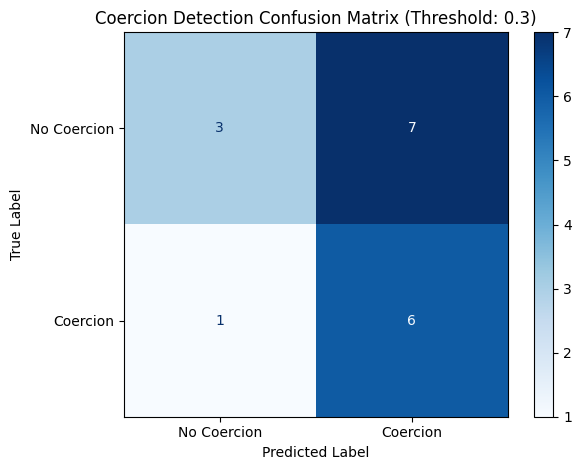

Accuracy: 0.53
Precision: 0.46
Recall: 0.86
F1 Score: 0.60



---- Confidence Threshold: 0.45 ----
Coercion Detection Accuracy: 58.82%
     video  coercion_detected  label  match
0  veriff1                  1      0  False
1  veriff2                  0      1  False
2  veriff3                  0      0   True
3  veriff4                  1      1   True
4  veriff5                  1      0  False


<Figure size 800x600 with 0 Axes>

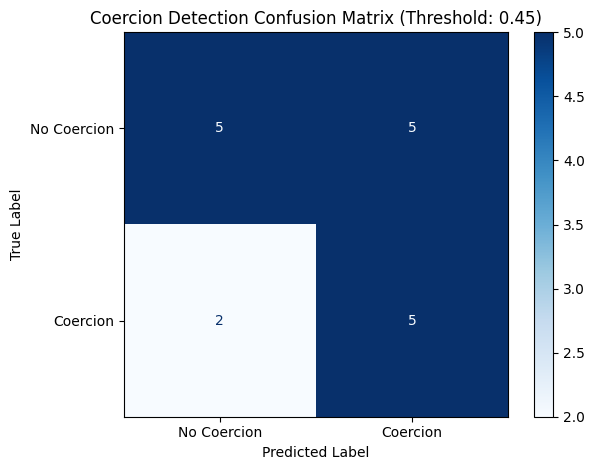

Accuracy: 0.59
Precision: 0.50
Recall: 0.71
F1 Score: 0.59



---- Confidence Threshold: 0.5 ----
Coercion Detection Accuracy: 58.82%
     video  coercion_detected  label  match
0  veriff1                  1      0  False
1  veriff2                  0      1  False
2  veriff3                  0      0   True
3  veriff4                  1      1   True
4  veriff5                  1      0  False


<Figure size 800x600 with 0 Axes>

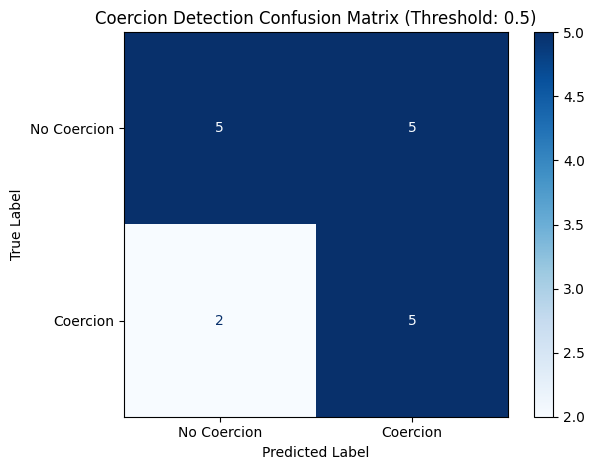

Accuracy: 0.59
Precision: 0.50
Recall: 0.71
F1 Score: 0.59



---- Confidence Threshold: 0.55 ----
Coercion Detection Accuracy: 58.82%
     video  coercion_detected  label  match
0  veriff1                  1      0  False
1  veriff2                  0      1  False
2  veriff3                  0      0   True
3  veriff4                  1      1   True
4  veriff5                  1      0  False


<Figure size 800x600 with 0 Axes>

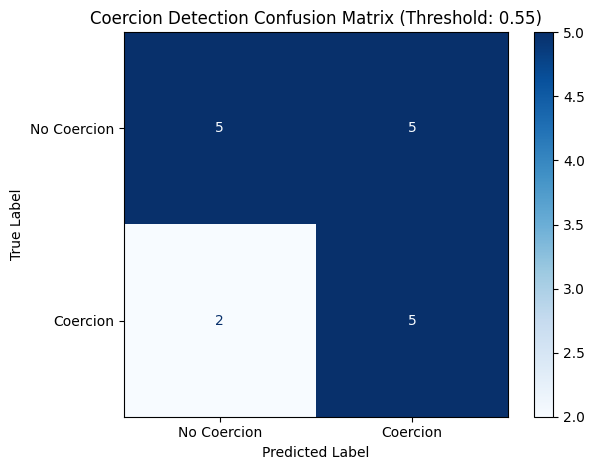

Accuracy: 0.59
Precision: 0.50
Recall: 0.71
F1 Score: 0.59



---- Confidence Threshold: 0.6 ----
Coercion Detection Accuracy: 70.59%
     video  coercion_detected  label  match
0  veriff1                  0      0   True
1  veriff2                  1      1   True
2  veriff3                  0      0   True
3  veriff4                  1      1   True
4  veriff5                  1      0  False


<Figure size 800x600 with 0 Axes>

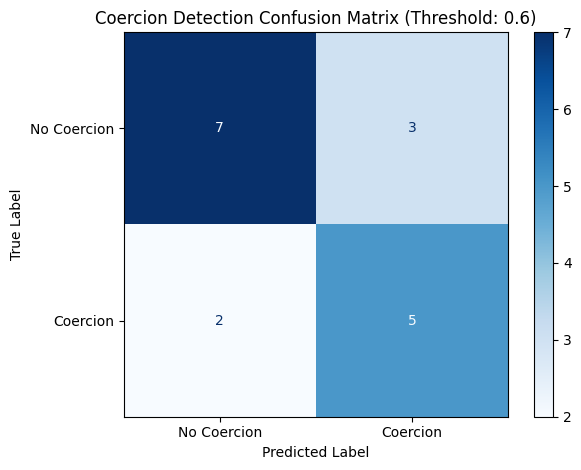

Accuracy: 0.71
Precision: 0.62
Recall: 0.71
F1 Score: 0.67



---- Confidence Threshold: 0.65 ----
Coercion Detection Accuracy: 58.82%
     video  coercion_detected  label  match
0  veriff1                  0      0   True
1  veriff2                  1      1   True
2  veriff3                  0      0   True
3  veriff4                  1      1   True
4  veriff5                  1      0  False


<Figure size 800x600 with 0 Axes>

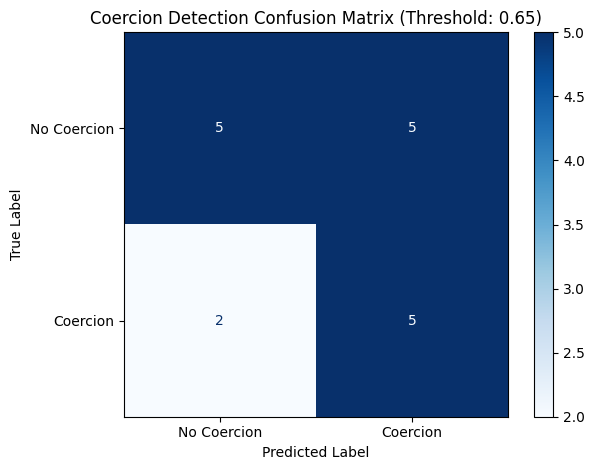

Accuracy: 0.59
Precision: 0.50
Recall: 0.71
F1 Score: 0.59


In [111]:
for threshold, (coercion_results, accuracy) in different_confidences_result.items():
    print(f"\n\n\n---- Confidence Threshold: {threshold} ----")
    print(f"Coercion Detection Accuracy: {accuracy:.2f}%")
    print(coercion_results.head())
    plot_confusion_matrix(coercion_results, threshold)


Based on this quite limited dataset and analysis, I would go with either the confidence=0.3 for great recall (meaning I'd catch most coerced videos) or confidence=0.6 (giving the best F1-score and balance between recall and precision, meaning we wouldn't bother non-coerced videos with false positives that much) models. Considering that the real-life dataset might be imbalanced towards there being fewer coerced videos, I would go with a higher confidence threshold conf=0.6.

# Results

I built a proof-of-concept for a coercion detection system that uses object-detection and tracking ML models. I then also fine-tuned the confidence threshold for object (face) detection and visualized its prediction accuracy metrics. I finally settled on a YOLOv8 (conf=0.6) + Deep SORT system and built the entire app around that. 